# Exercise 4 (Training without Bayes Optimization)

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

dfWind = pd.read_csv('../data/data_wind_preprocessed1.csv')
dfWind.head()

,Wind direction (gr),Wind gust max (m/s),Relative humidity min,Precipitation (m),Wind speed (m/s),Date,Hour
0,0.809017,3.8,0.60,0.0,1.8,2000-01-01 12:00:00,12
1,0.965926,4.7,0.55,0.0,2.7,2000-01-01 13:00:00,13
2,0.891007,4.9,0.50,0.0,2.0,2000-01-01 14:00:00,14
3,0.848048,5.8,0.44,0.0,2.5,2000-01-01 15:00:00,15
4,0.224951,5.8,0.43,0.0,2.4,2000-01-01 16:00:00,16


In [3]:
dfWind.shape

(90276, 7)

## Defining models and their parameters

In [4]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR

n_col = dfWind.shape[1]

models_dict = {
    'SVR': {
        'model': SVR(),
        'scalers': {
            'scaler': [MinMaxScaler(), StandardScaler()]
        },
        'grid': {
            'model__C': [10**k for k in range(-3, 4)],
            'model__epsilon': [10**k for k in range(-3, 4)],
        },
        'best_params': {},
        'n_days': [1, 3, 7, 14, 21, 30, 60]
    },

    'Linear Regression': {
        'model': LinearRegression(),
        'scalers': {
            'scaler': [None, MinMaxScaler(), StandardScaler()]
        },
        'grid': {},
        'best_params': {},
        'n_days': [1, 3, 7, 14, 21, 30, 60, 90, 180, 365]
    },

    'Bayesian Ridge': {
        'model': BayesianRidge(),
        'scalers': {
            'scaler': [None, MinMaxScaler(), StandardScaler()]
        },
        'grid': {
            'model__alpha_1': [10**k for k in range(-6, -2)],
            'model__alpha_2': [10**k for k in range(-6, -2)],
            'model__lambda_1': [10**k for k in range(-6, -2)],
            'model__lambda_2': [10**k for k in range(-6, -2)],
        },
        'best_params': {},
        'n_days': [1, 3, 7, 14, 21, 30, 60, 90, 180, 365]
    },

    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'scalers': {
            'scaler': [None]
        },
        'grid': {
            'model__max_depth': range(1, 50),
        },
        'best_params': {},
        'n_days': [1, 3, 7, 14, 21, 30, 60, 90, 180, 365]
    },

    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'scalers': {
            'scaler': [None]
        },
        'grid': {
            'model__max_depth': range(1, 50),
            'model__n_estimators': [10, 30, 50, 100, 200],
        },
        'best_params': {},
        'n_days': [1, 3, 7, 14, 21, 30, 60, 90, 180, 365]
    },

    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'scalers': {
            'scaler': [None]
        },
        'grid': {
            'model__max_depth': range(1, n_col + 1),
            'model__n_estimators': [10, 30, 50, 100, 200],            
        },
        'best_params': {},
        'n_days': [1, 3, 7, 14, 21, 30, 60, 90, 180, 365]
    },

    'K-NN': {
        'model': KNeighborsRegressor(n_jobs=-1),
        'scalers': {
            'scaler': [None, MinMaxScaler(), StandardScaler()]
        },
        'grid': {
            'model__n_neighbors': range(1, 20),
        },
        'best_params': {},
        'n_days': [1, 3, 7, 14, 21, 30, 60, 90, 180, 365]
    },

    'Ridge': {
        'model': Ridge(random_state=42),
        'scalers': {
            'scaler': [None, MinMaxScaler(), StandardScaler()]
        },
        'grid': {
            'model__alpha': [10**k for k in range(-3, 4)]
        },
        'best_params': {},
        'n_days': [1, 3, 7, 14, 21, 30, 60, 90, 180, 365]
    },

    'Lasso': {
        'model': Lasso(random_state=42),
        'scalers': {
            'scaler': [None, MinMaxScaler(), StandardScaler()]
        },
        'grid': {
            'model__alpha': [10**k for k in range(-3, 4)]
        },
        'best_params': {},
        'n_days': [1, 3, 7, 14, 21, 30, 60, 90, 180, 365]
    },
}

In [5]:
results_dict = {
        name:{
            numDays: {
                'model': None, 'pred': [], 'test': [], 'cpu_time': None, 'MAPEs': [], 'R2s': [], 'RMSEs': []
            } for numDays in models_dict[name]['n_days']
        } for name in models_dict
}

print(results_dict)

{'SVR': {1: {'model': None, 'pred': [], 'test': [], 'cpu_time': None, 'MAPEs': [], 'R2s': [], 'RMSEs': []}, 3: {'model': None, 'pred': [], 'test': [], 'cpu_time': None, 'MAPEs': [], 'R2s': [], 'RMSEs': []}, 7: {'model': None, 'pred': [], 'test': [], 'cpu_time': None, 'MAPEs': [], 'R2s': [], 'RMSEs': []}, 14: {'model': None, 'pred': [], 'test': [], 'cpu_time': None, 'MAPEs': [], 'R2s': [], 'RMSEs': []}, 21: {'model': None, 'pred': [], 'test': [], 'cpu_time': None, 'MAPEs': [], 'R2s': [], 'RMSEs': []}, 30: {'model': None, 'pred': [], 'test': [], 'cpu_time': None, 'MAPEs': [], 'R2s': [], 'RMSEs': []}, 60: {'model': None, 'pred': [], 'test': [], 'cpu_time': None, 'MAPEs': [], 'R2s': [], 'RMSEs': []}}, 'Linear Regression': {1: {'model': None, 'pred': [], 'test': [], 'cpu_time': None, 'MAPEs': [], 'R2s': [], 'RMSEs': []}, 3: {'model': None, 'pred': [], 'test': [], 'cpu_time': None, 'MAPEs': [], 'R2s': [], 'RMSEs': []}, 7: {'model': None, 'pred': [], 'test': [], 'cpu_time': None, 'MAPEs': [],

## Hyperparametrization

We find the best parameters only on the first set

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from copy import deepcopy
from time import time
import os
import pickle

path_tuning = '../pickle/wind/tuning_gs.pkl'

if not os.path.exists(path_tuning):
    X = dfWind.drop(columns=['Wind speed (m/s)', 'Date'])
    y = dfWind['Wind speed (m/s)']
    for name in models_dict:
        print(f"Tuning {name}...")
        model_dict = models_dict[name]
        param_grid = {
            **model_dict['scalers'],
            **model_dict['grid']
        }
        for numDays in model_dict['n_days']:
            X_train = X.iloc[0:numDays*24]
            y_train = y.iloc[0:numDays*24]
            steps = [
                ('scaler', None),
                ('model', deepcopy(model_dict['model']))
            ]
            pipeline = Pipeline(steps)
            search_cv = GridSearchCV(pipeline, param_grid, scoring='r2', cv=5, n_jobs=-1)
            start = time()
            search_cv.fit(X_train, y_train)
            end = time()
            results_dict[name][numDays]['model'] = search_cv.best_estimator_
            model_dict['best_params'][numDays] = search_cv.best_params_
            print(f"{numDays} days => {round(end - start, 1)}s => {search_cv.best_params_}")
        print()
    with open(path_tuning, 'wb') as f:
        pickle.dump(results_dict, f)
else:
    with open(path_tuning, 'rb') as f:
        results_dict = pickle.load(f)
    for name in models_dict:
        print(f"Best params for {name}: ")
        for numDays in models_dict[name]['n_days']:
            print(f"{numDays} days => {results_dict[name][numDays]['model'].named_steps['model']}")
        print()

Best params for SVR: 
1 days => SVR(C=1)
3 days => SVR(C=1, epsilon=0.001)
7 days => SVR(C=1, epsilon=0.001)
14 days => SVR(C=1, epsilon=0.01)
21 days => SVR(C=1, epsilon=0.01)
30 days => SVR(C=1)
60 days => SVR(C=1, epsilon=0.01)

Best params for Linear Regression: 
1 days => LinearRegression()
3 days => LinearRegression()
7 days => LinearRegression()
14 days => LinearRegression()
21 days => LinearRegression()
30 days => LinearRegression()
60 days => LinearRegression()
90 days => LinearRegression()
180 days => LinearRegression()
365 days => LinearRegression()

Best params for Bayesian Ridge: 
1 days => BayesianRidge(alpha_1=0.001, lambda_2=0.001)
3 days => BayesianRidge(alpha_2=0.001, lambda_1=0.001)
7 days => BayesianRidge(alpha_2=0.001, lambda_1=0.001)
14 days => BayesianRidge(alpha_2=0.001, lambda_1=0.001)
21 days => BayesianRidge(alpha_1=0.001, lambda_2=0.001)
30 days => BayesianRidge(alpha_1=0.001, lambda_2=0.001)
60 days => BayesianRidge(alpha_1=0.001, lambda_2=0.001)
90 days =>

## Training

In [7]:
from utils import model_evaluation_lr
from time import time
import os
import pickle

path_results = '../pickle/wind/results_gs.pkl'

if not os.path.exists(path_results):
    dict_pred = {}
    X = dfWind.drop(columns=['Wind speed (m/s)', 'Date'])
    y = dfWind['Wind speed (m/s)']

    for i, name in enumerate(models_dict):
        model_dict = models_dict[name]
        print(f"Training {name}...")
        for numDays in model_dict['n_days']:
            best_params_cleaned = {k.replace('model__', ''): v for k, v in model_dict['best_params'][numDays].items() if k.startswith('model__')}
            pipeline = Pipeline(
                [
                    ('scaler', model_dict['best_params'][numDays]['scaler']),
                    ('model', deepcopy(model_dict['model']).set_params(**best_params_cleaned)),
                ]
            )
            print(f'{numDays} days', end='')
            start = time()
            for j in range(0, dfWind.shape[0] - (numDays + 1)*24, 24):
                X_train = X.iloc[j:j+numDays*24]
                y_train = y.iloc[j:j+numDays*24]
                X_valid = X.iloc[j+numDays*24:j+((numDays + 1)*24)]
                y_valid = y.iloc[j+numDays*24:j+((numDays + 1)*24)]
                
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_valid)
                eval_lr = model_evaluation_lr(y_pred, y_valid)

                results_numDays = results_dict[name][numDays]
                results_numDays['pred'] += y_pred.tolist()
                results_numDays['test'] += y_valid.tolist()
                results_numDays['MAPEs'].append(eval_lr['mape'])
                results_numDays['R2s'].append(eval_lr['r2'])
                results_numDays['RMSEs'].append(eval_lr['rmse'])
            end = time()
            cpu_time = round(end - start, 1)
            print(f" => {cpu_time}s")
            results_numDays['cpu_time'] = cpu_time
        print()
    with open(path_results, 'wb') as f:
        pickle.dump(results_dict, f)
else:
    with open(path_results, 'rb') as f:
        results_dict = pickle.load(f)

## Results

In [8]:
results_overall = pd.DataFrame(columns=['Model', 'CPU time', 'MAPE', 'R2', 'RMSE'])

for name in results_dict:
    model_dict = models_dict[name]
    for numDays in model_dict['n_days']:
        results = results_dict[name][numDays]
        eval = model_evaluation_lr(results['pred'], results['test'])
        new_row = {
            'Model': f"{name} ({numDays} days)",
            'CPU time': results['cpu_time'],
            'MAPE': eval['mape'],
            'R2': eval['r2'],
            'RMSE': eval['rmse']
        }
        results_overall = pd.concat([results_overall, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [9]:
results_overall.sort_values('R2', ascending=False, inplace=True)
print(results_overall.to_string(index=False))

                       Model  CPU time         MAPE    R2  RMSE
Gradient Boosting (365 days)     918.0 2.230000e-01 0.761 0.568
    Random Forest (365 days)    4452.7 2.380000e-01 0.760 0.574
 Gradient Boosting (90 days)     673.1 2.500000e-01 0.755 0.584
Gradient Boosting (180 days)    1127.6 2.390000e-01 0.754 0.582
    Random Forest (180 days)    2612.1 2.460000e-01 0.751 0.585
     Random Forest (60 days)    1222.0 2.450000e-01 0.746 0.592
 Gradient Boosting (60 days)     263.1 3.420000e-01 0.745 0.585
     Random Forest (90 days)      82.8 2.044674e+10 0.742 0.596
    Decision Tree (365 days)      34.4 4.199470e+11 0.739 0.602
 Gradient Boosting (30 days)     185.1 2.480000e-01 0.737 0.595
               SVR (60 days)     207.0 2.250000e-01 0.734 0.591
             K-NN (365 days)      76.8 2.260000e-01 0.732 0.596
Linear Regression (365 days)      11.3 2.510000e-01 0.726 0.608
            Ridge (365 days)       7.4 2.660000e-01 0.726 0.608
   Bayesian Ridge (365 days)      12.1 2

We can see that Gradient Boosting and Random Forest are the best models for this dataset with the highest R2 and lowest RMSE. However, the CPU time for these models is significantly higher than the other models or with less days. For a real-time application, we should consider using a simpler model like Ridge Regression who has a good R2 and RMSE with a lower CPU time.  

We can also notice that the performance of the models is better when we use more days to predict the wind speed. On the one hand this not expected because the wind speed is a chaotic system very dependant on the last values. On the other hand, the models have more data to learn from and can make better predictions.  

That's why it would be interesting to test the models with all the dataset without taking into account the days to see if the models can learn from the data.  

Moreover, we have seen that almost every predictors have a high autocorrelation with the same hour of the previous days. We could use this information to predict the wind speed and train only with the same hours. This would be a very interesting approach to test.

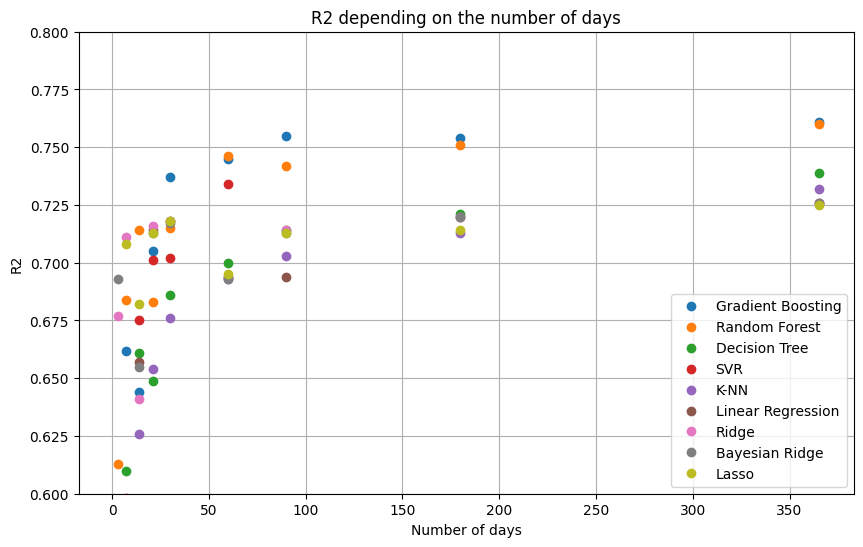

In [10]:
import matplotlib.pyplot as plt

results_overall['Name'] = results_overall['Model'].apply(lambda x: x.split('(')[0][:-1])
results_overall['Days'] = results_overall['Model'].apply(lambda x: int(x.split('(')[1].split(' ')[0]))
results_overall[['Name', 'Days', 'R2']]

plt.figure(figsize=(10, 6))

for name in results_overall['Name'].unique():
    plt.plot(
        results_overall[results_overall['Name'] == name]['Days'],
        results_overall[results_overall['Name'] == name]['R2'],
        label=name, marker='o', linestyle='')

plt.xlabel('Number of days')
plt.ylim(0.6, 0.8)
plt.ylabel('R2')
plt.title('R2 depending on the number of days')
plt.legend()
plt.grid()
plt.show()

This graph confirms that we have better results when we use more days to predict the wind speed.

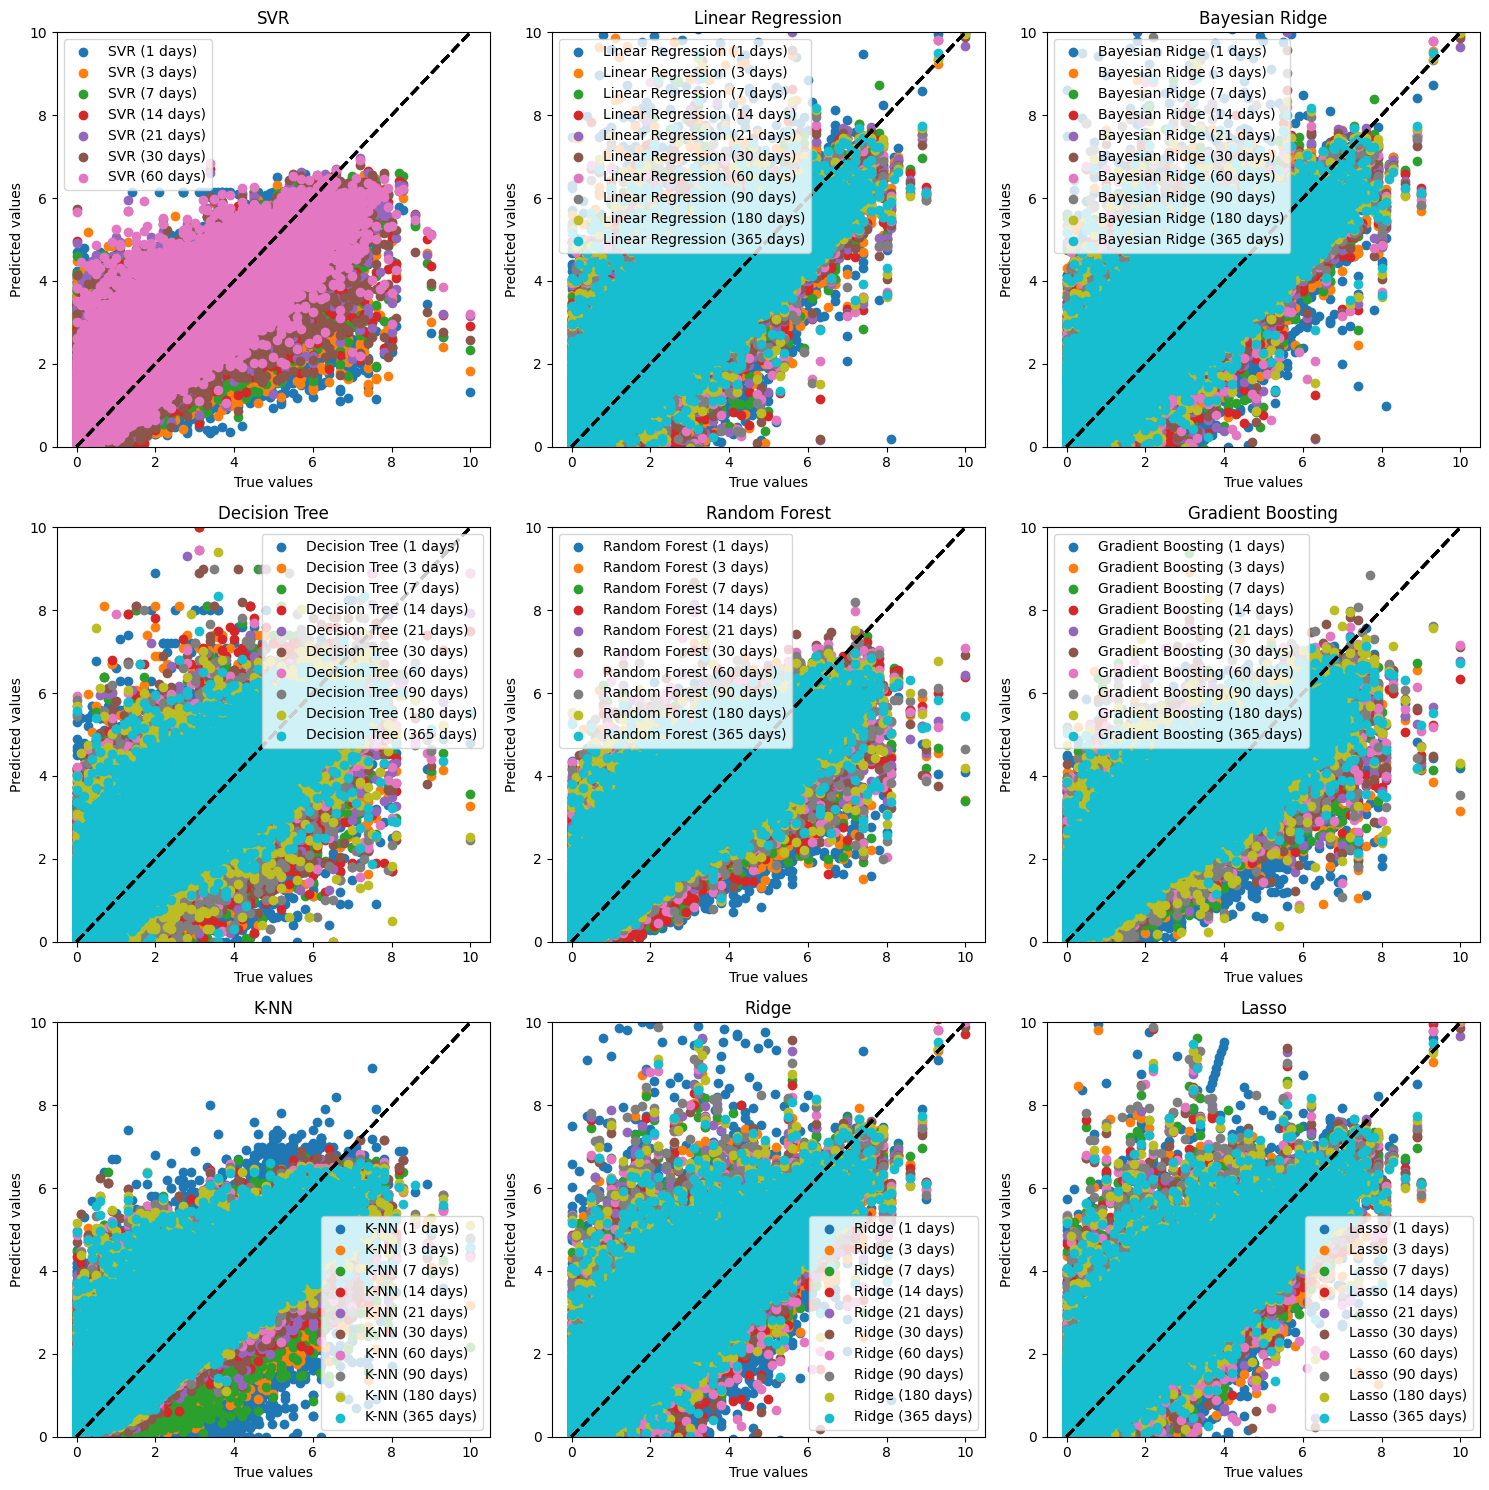

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

for i, name in enumerate(results_dict):
    for numDays in models_dict[name]['n_days']:
        results = results_dict[name][numDays]
        y_pred = results['pred']
        y_test = results['test']
        axs[i].plot([0, max(y_test)], [0, max(y_test)], 'k--', lw=2)
        axs[i].scatter(y_test, y_pred, label=f"{name} ({numDays} days)")
        axs[i].set_ylim(0, max(y_test))
        axs[i].set_title(f"{name}")
        axs[i].set_xlabel('True values')
        axs[i].set_ylabel('Predicted values')
        axs[i].legend()

plt.tight_layout()
plt.show()

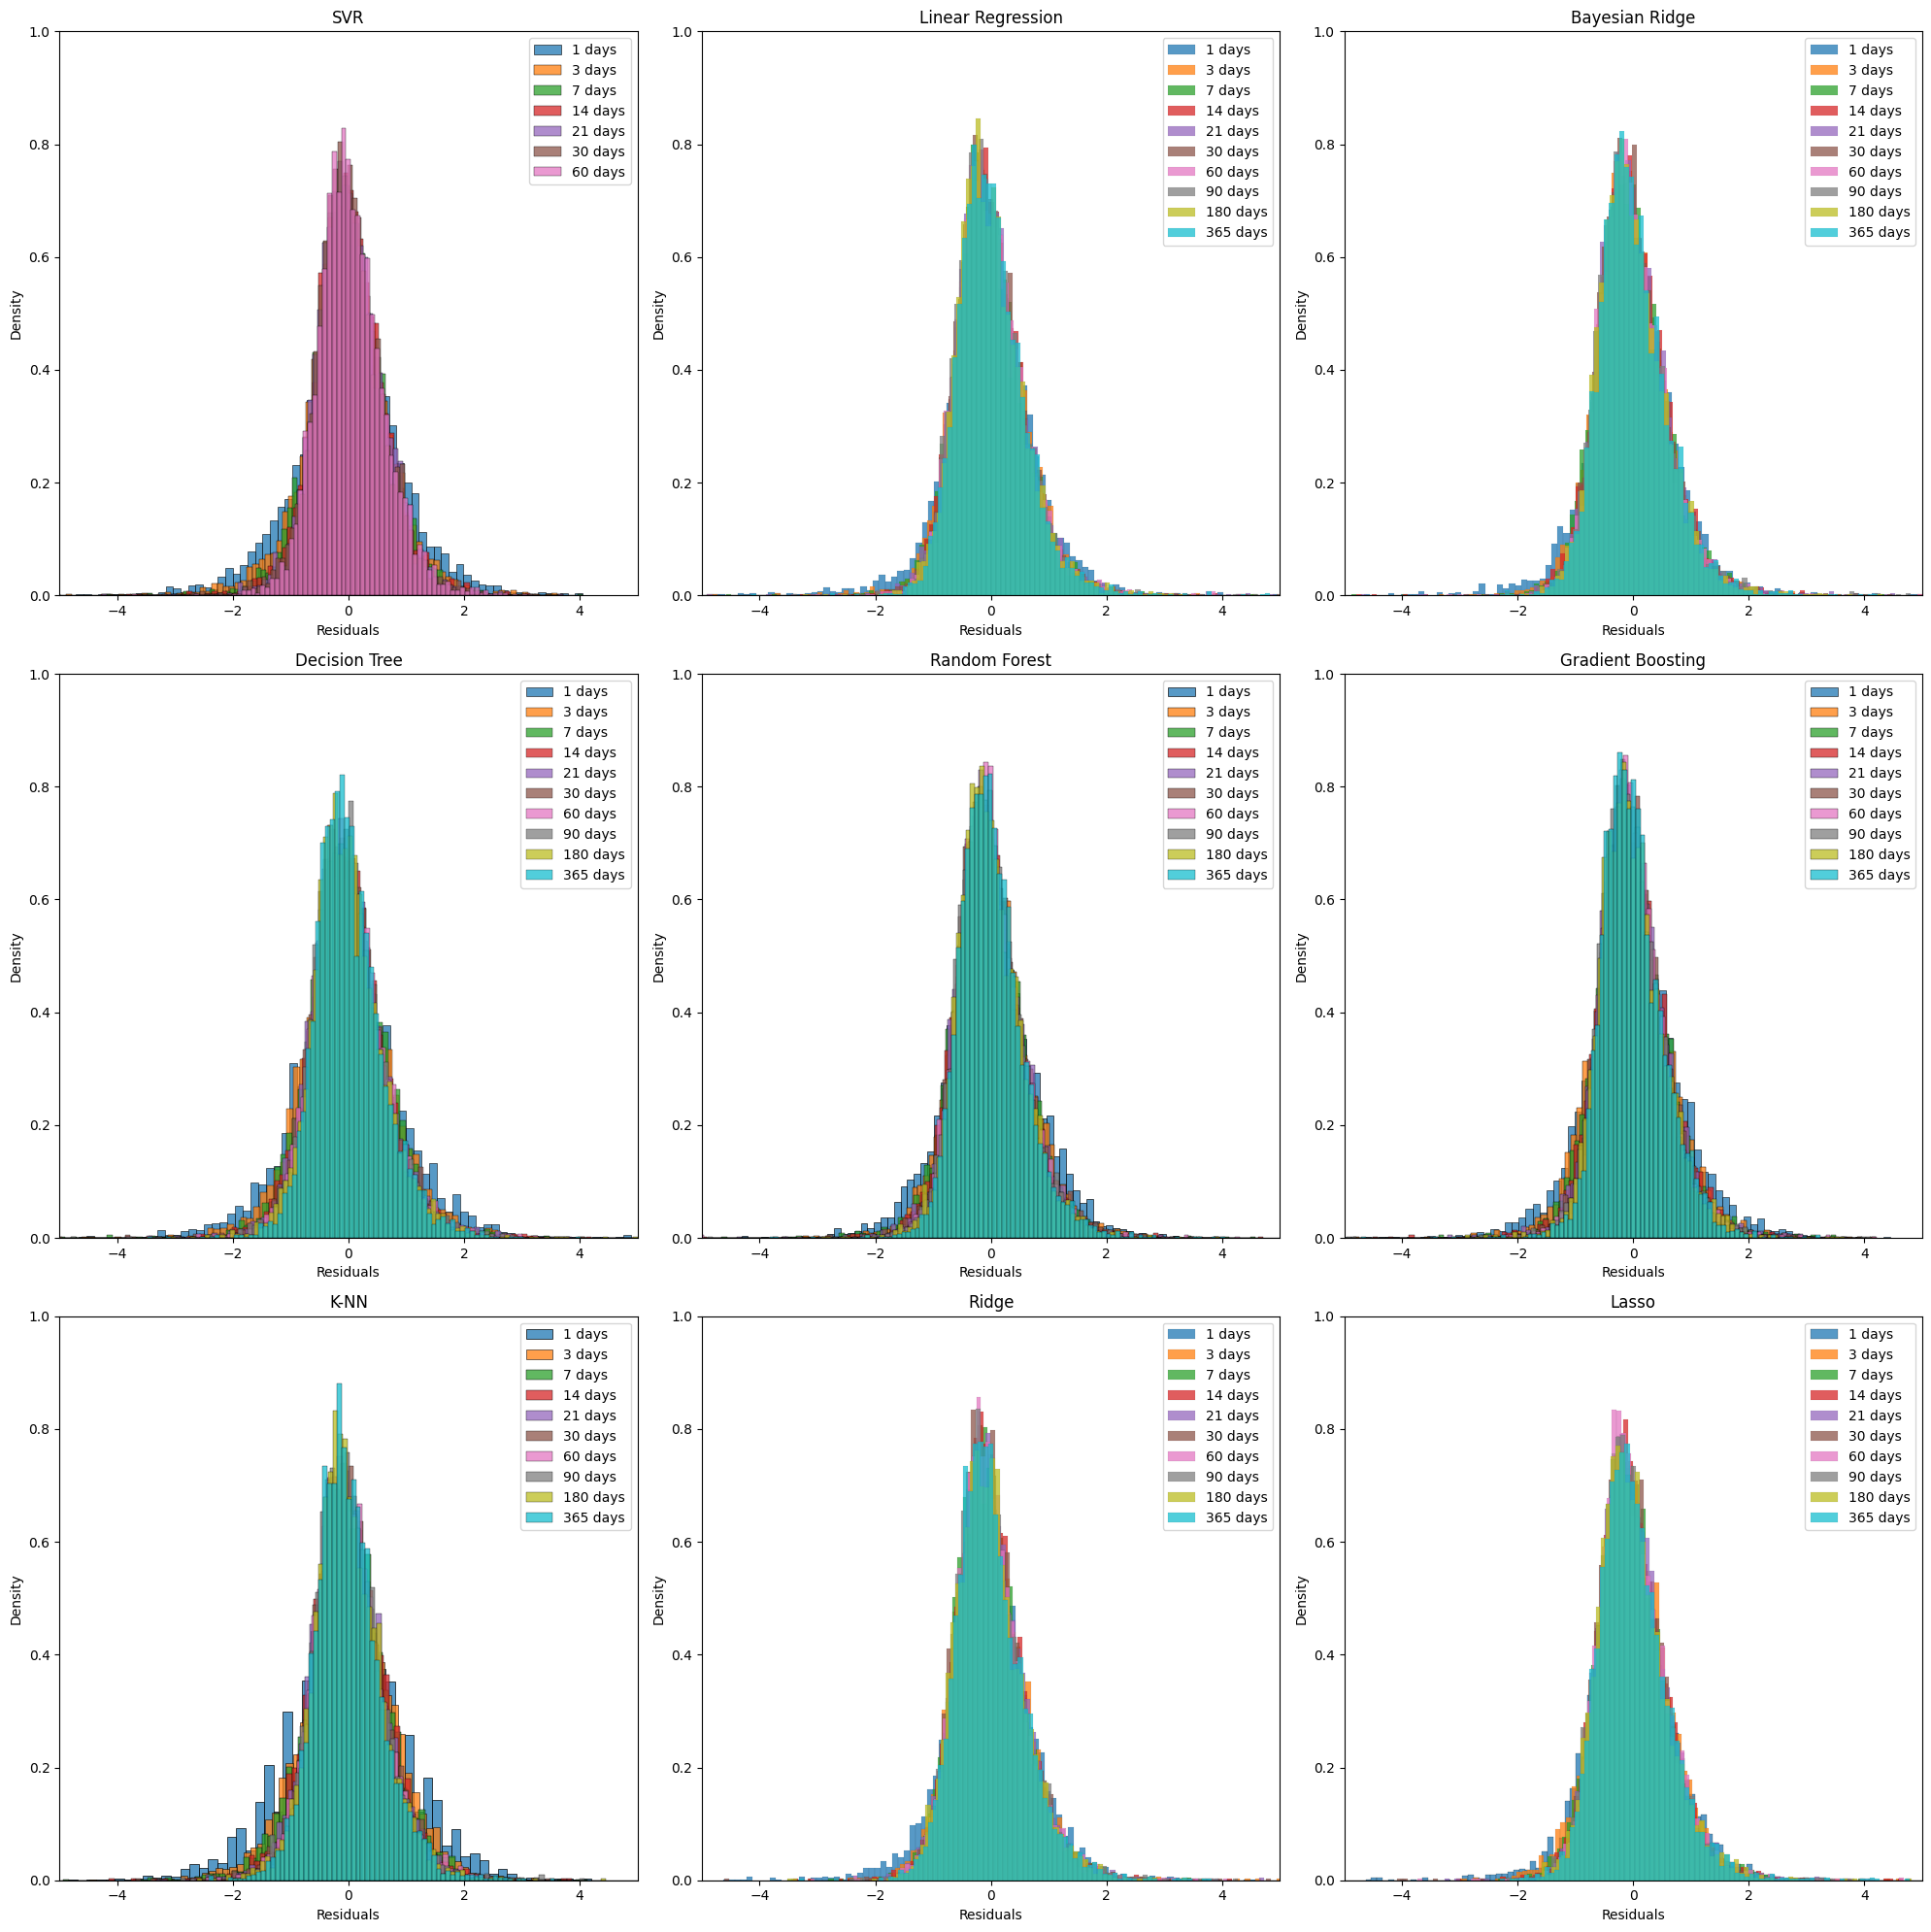

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()

for i, name in enumerate(results_dict):
    for numDays in models_dict[name]['n_days']:
        pred = results_dict[name][numDays]['pred']
        test = results_dict[name][numDays]['test']
        residuals = rd.sample([val_pred - val_test for val_pred, val_test in zip(pred, test)], 5000)
        sns.histplot(residuals, ax=axs[i], label=f"{numDays} days", stat='density')

    axs[i].set_title(f"{name}")
    axs[i].set_xlabel('Residuals')
    axs[i].set_ylabel('Density')
    axs[i].set_xlim(-5, 5)
    axs[i].set_ylim(0, 1)
    axs[i].legend()

plt.tight_layout()
plt.show()

In [13]:
from scipy.stats import norm, shapiro

df_gaussian_test = pd.DataFrame(columns=['Model', 'Mean', 'Std', 'p_value'])

for i, name in enumerate(results_dict):
    for numDays in models_dict[name]['n_days']:
        pred = results_dict[name][numDays]['pred']
        test = results_dict[name][numDays]['test']
        residuals = [val_pred - val_test for val_pred, val_test in zip(pred, test)]
        mean, std = norm.fit(residuals)
        _, p_value = shapiro(residuals)
        new_row = {
            'Model': f"{name} ({numDays} days)",
            'Mean': round(mean, 2),
            'Std': round(std, 2),
            'p_value': round(p_value, 2)
        }
        df_gaussian_test = pd.concat([df_gaussian_test, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [14]:
df_gaussian_test.sort_values('Std', inplace=True)
print(df_gaussian_test.to_string(index=False))

                       Model  Mean  Std  p_value
    Random Forest (365 days)  0.00 0.57      0.0
Gradient Boosting (365 days)  0.00 0.57      0.0
 Gradient Boosting (90 days) -0.01 0.58      0.0
    Random Forest (180 days) -0.01 0.58      0.0
Gradient Boosting (180 days) -0.01 0.58      0.0
 Gradient Boosting (60 days) -0.01 0.59      0.0
     Random Forest (60 days) -0.02 0.59      0.0
               SVR (60 days)  0.03 0.59      0.0
    Decision Tree (365 days)  0.00 0.60      0.0
             K-NN (365 days)  0.02 0.60      0.0
 Gradient Boosting (30 days) -0.02 0.60      0.0
     Random Forest (90 days) -0.01 0.60      0.0
              K-NN (90 days)  0.00 0.61      0.0
             K-NN (180 days)  0.00 0.61      0.0
 Gradient Boosting (21 days) -0.02 0.61      0.0
            Ridge (180 days) -0.01 0.61      0.0
            Ridge (365 days)  0.01 0.61      0.0
     Random Forest (30 days) -0.01 0.61      0.0
   Bayesian Ridge (365 days)  0.01 0.61      0.0
            Lasso (3

Here, we can notice that all the models have a p-value very close to 0 which means we can affirm with a very high confidence that the residuals are normally distributed which is a good sign beacause it means that the model is well fitted.  

Once more we can affirm that the best models are Gradient Boosting and Random Forest because their residuals have the lowest standard deviation and a mean very close to 0.

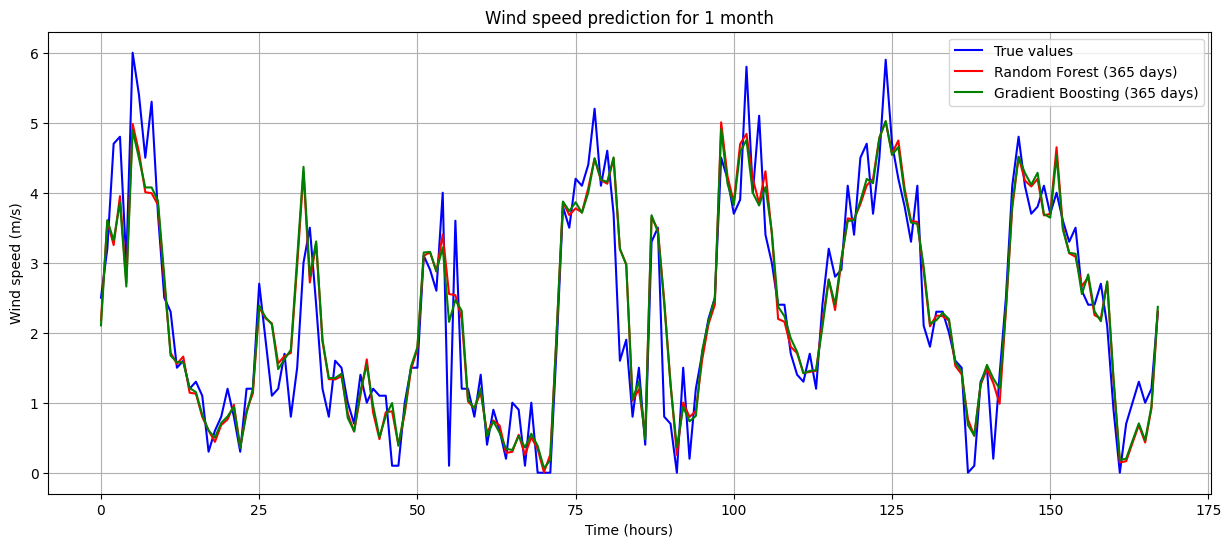

In [15]:
import random as rd
rd.seed(42)

y_test_RF_365 = results_dict['Random Forest'][365]['test']
y_pred_RF_365 = results_dict['Random Forest'][365]['pred']

y_test_GB_365 = results_dict['Gradient Boosting'][365]['test']
y_pred_GB_365 = results_dict['Gradient Boosting'][365]['pred']

plt.figure(figsize=(15, 6))
idx_rd = rd.randint(0, len(y_test_RF_365) - 24*7)
plt.plot(y_test_RF_365[idx_rd:idx_rd + 24*7], label='True values', color='blue')
plt.plot(y_pred_RF_365[idx_rd:idx_rd + 24*7], label='Random Forest (365 days)', color='red')
plt.plot(y_pred_GB_365[idx_rd:idx_rd + 24*7], label='Gradient Boosting (365 days)', color='green')
plt.xlabel('Time (hours)')
plt.ylabel('Wind speed (m/s)')
plt.title('Wind speed prediction for 1 month')
plt.legend()
plt.grid()
plt.show()

We can see that predictions follow quite well the true values even if the wind speed is quite volatile.